In [ ]:
# default_exp analyse_purchases

# Analyse purchases
> compute keywords in product descriptions, Kmeans clustering, PCA analysis

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
# export
from typing import List
import logging
import pandas as pd
import numpy as np
import nltk

In [ ]:
# export
def _prepare_nltk():
    nltk.download('punkt')
    nltk.download('averaged_perceptron_tagger')

In [ ]:
# hide
logging.basicConfig(level=logging.INFO)

### Compute keywords: list of products

Original section: 3.1 Products Description. Original cells: 22-27

In [ ]:
# export
def _keywords_inventory(dataframe, colonne = 'Description'):
    def is_noun(pos):
        return pos[:2] == 'NN'
    
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    #print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [ ]:
# export

def build_product_list(df: pd.DataFrame) -> pd.DataFrame:   
    _prepare_nltk()
    
    df_initial = df
    df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})
    
    keywords, keywords_roots, keywords_select, count_keywords = _keywords_inventory(df_produits)
    
    list_products = []
    for k,v in count_keywords.items():
        #list_products.append([keywords_select[k],v])
        # XXX: here we also filter out useless ones
        word = keywords_select[k]
        if word in ['pink', 'blue', 'tag', 'green', 'orange']:
            continue
        if len(word) < 3 or v < 13:
            continue
        if ('+' in word) or ('/' in word):
            continue
        list_products.append([word, v])
    list_products.sort(key = lambda x:x[1], reverse = True)
    return list_products

In [ ]:
# export
import matplotlib.pyplot as plt

def plot_product_list_histogram(list_products):
    liste = sorted(list_products, key = lambda x:x[1], reverse = True)
    
    plt.rc('font', weight='normal')
    fig, ax = plt.subplots(figsize=(7, 25))
    y_axis = [i[1] for i in liste[:125]]
    x_axis = [k for k,i in enumerate(liste[:125])]
    x_label = [i[0] for i in liste[:125]]
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 13)
    plt.yticks(x_axis, x_label)
    plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
    ax.barh(x_axis, y_axis, align = 'center')
    ax = plt.gca()
    ax.invert_yaxis()
    
    plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
    plt.show()

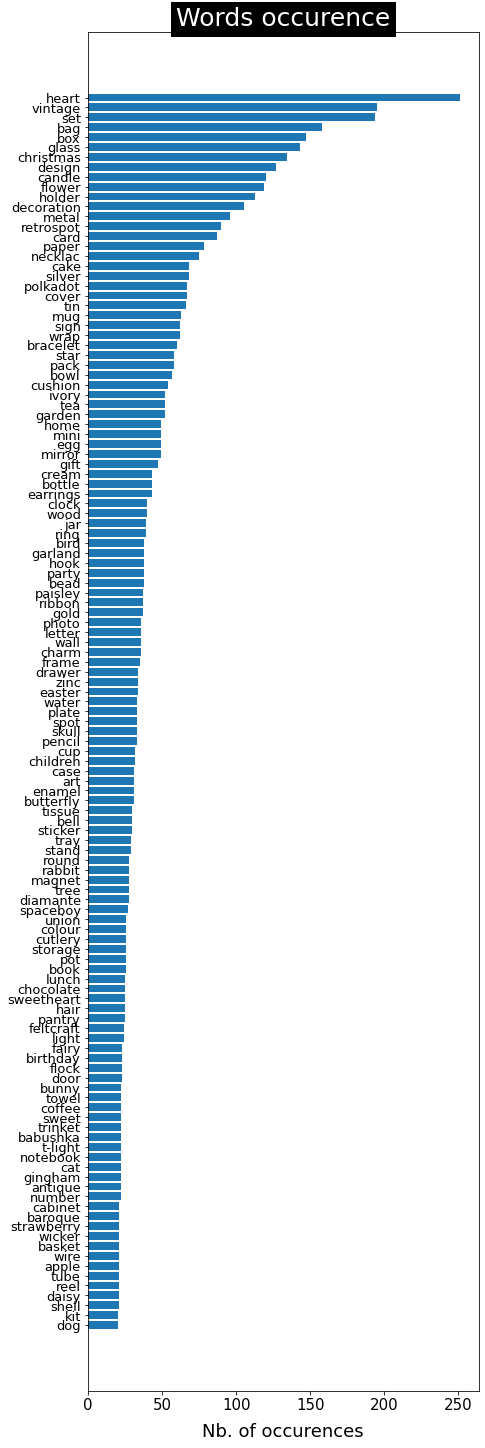

In [ ]:
from customer_segmentation_toolkit.load_split import load_data_csv

df = load_data_csv('../data/output/02_data_clean_rows/no_live_data__cleaned.csv')
list_products = build_product_list(df)
plot_product_list_histogram(list_products)

### Compute keywords: analyse product category
Original section: 3.2 Defining product categories. Oritinal cells: 28-30

In [ ]:
# export

def build_keywords_matrix(
    df: pd.DataFrame,
    list_products: List[str],
    threshold: List[int] = (0, 1, 2, 3, 5, 10),
) -> pd.DataFrame:
    # TODO: rename: liste_produits vs list_products

    liste_produits = df['Description'].unique()
    
    X = pd.DataFrame()
    for key, occurence in list_products:
        X.loc[:, key] = list(map(lambda x: int(key.upper() in x), liste_produits))
    
    label_col = []
    for i in range(len(threshold)):
        if i == len(threshold)-1:
            col = '.>{}'.format(threshold[i])
        else:
            col = '{}<.<{}'.format(threshold[i],threshold[i+1])
        label_col.append(col)
        X.loc[:, col] = 0

    df_cleaned = df
    for i, prod in enumerate(liste_produits):
        prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
        j = 0
        while prix > threshold[j]:
            j+=1
            if j == len(threshold): break
        X.loc[i, label_col[j-1]] = 1
    
    return X

In [ ]:
# export

def display_keywords_matrix(X: pd.DataFrame, threshold: List[int] = (0, 1, 2, 3, 5, 10)):
    print("{:<8} {:<20} \n".format('gamme', 'nb. produits') + 20*'-')
    for i in range(len(threshold)):
        if i == len(threshold)-1:
            col = '.>{}'.format(threshold[i])
        else:
            col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
        print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

In [ ]:
df = df[:1000]
matrix = build_keywords_matrix(df, list_products)
display_keywords_matrix(matrix)
matrix[:5]

gamme    nb. produits         
--------------------
0<.<1       118                 
1<.<2       203                 
2<.<3       119                 
3<.<5       92                  
5<.<10      61                  
.>10        15                  


,heart,vintage,set,bag,box,glass,christmas,design,candle,flower,...,medium,hen,wallet,point,0<.<1,1<.<2,2<.<3,3<.<5,5<.<10,.>10
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Analyse keywords: build clusters of products via Kmeans

Original section: 3.2.2 Creating clusters of products. Original cells: 31-35

In [ ]:
# export

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
# export

def compute_purchase_clusters(
    matrix: np.ndarray,
    n_clusters: int,
) -> np.ndarray:   
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    return clusters

In [ ]:
N_CLUSTERS = 5

In [ ]:
clusters = compute_purchase_clusters(matrix, N_CLUSTERS)

silhouette_avg = silhouette_score(matrix, clusters)
sample_silhouette_values = silhouette_samples(matrix, clusters)

silhouette_avg, sample_silhouette_values[:4]
clusters.shape, pd.Series(clusters).value_counts()

((608,),
 2    240
 4    173
 1    101
 3     55
 0     39
 dtype: int64)

In [ ]:
# export

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):

        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

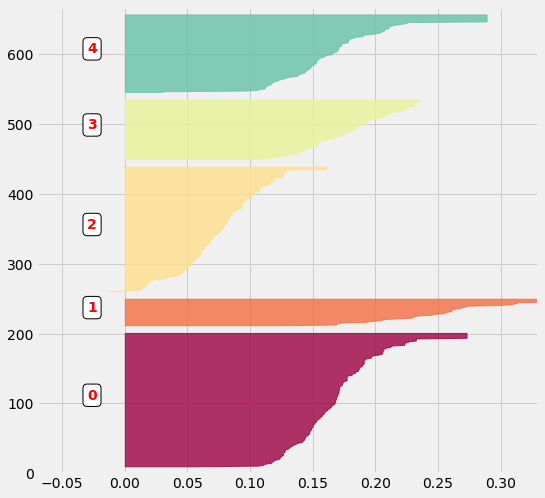

In [ ]:
plot_silhouette(N_CLUSTERS, [-0.07, 0.33], len(matrix), sample_silhouette_values, clusters)

### Analyse keywords: PCA

Original cells: 38-41. Note: not exporting this code to python files.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

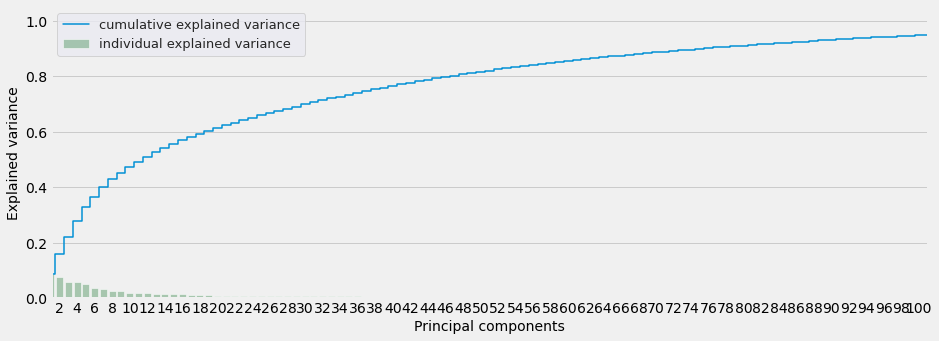

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

In [ ]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

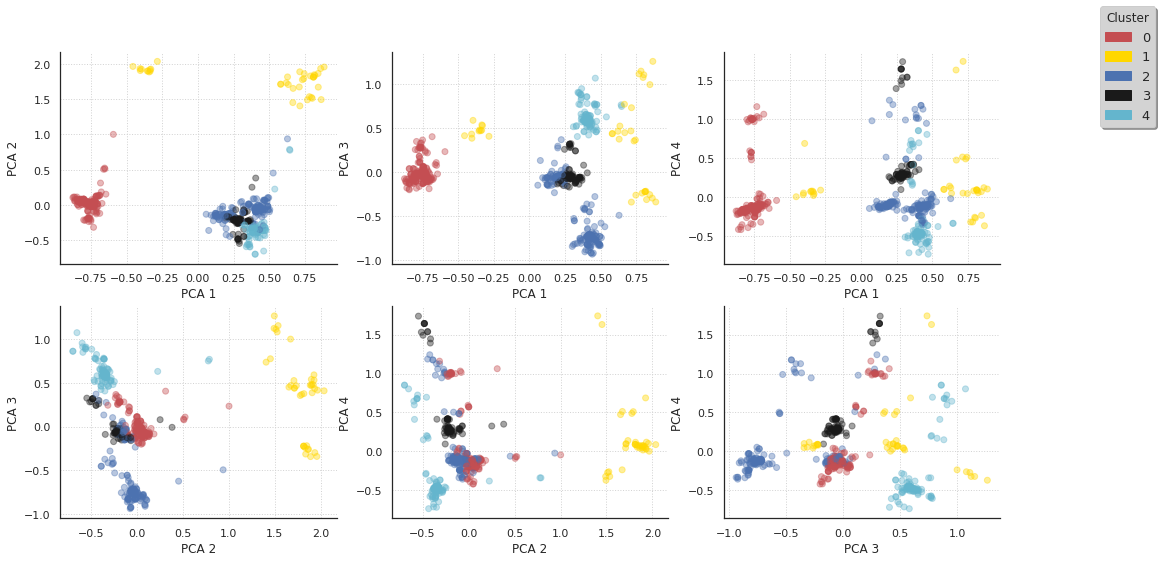

In [ ]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

### Construct a new DataFrame with product clusters info

Original section: 4.1 Formatting data. Original cells: 42-44

In [ ]:
# export

def add_purchase_clusters_info(
    df: pd.DataFrame,
    clusters: np.ndarray,
    n_clusters: int,
):
    df_cleaned = df.copy(deep=True)
    del df
    
    liste_produits = df_cleaned['Description'].unique()
    corresp = dict()
    for key, val in zip (liste_produits, clusters):
        corresp[key] = val 
    df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)
    
    for i in range(n_clusters):
        col = 'categ_{}'.format(i)        
        df_temp = df_cleaned[df_cleaned['categ_product'] == i]
        price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
        price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
        df_cleaned.loc[:, col] = price_temp
        df_cleaned[col].fillna(0, inplace = True)
    # Up to now, the information related to a single order was split over several lines
    # of the dataframe (one line per product). I decide to collect the information related 
    # to a particular order and put in in a single entry. I therefore create a new dataframe 
    # that contains, for each order, the amount of the basket, as well as the way it is 
    # distributed over the 5 categories of products:

    # somme des achats / utilisateur & commande
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
    basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

    # pourcentage du prix de la commande / categorie de produit
    for i in range(n_clusters):
        col = 'categ_{}'.format(i) 
        temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
        basket_price.loc[:, col] = temp[col]

    # date de la commande
    df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
    df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
    basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

    # selection des entrées significatives:
    basket_price = basket_price[basket_price['Basket Price'] > 0]
    basket_price.sort_values('CustomerID', ascending = True)[:5]
    
    return basket_price

In [ ]:
df_with_clusters = add_purchase_clusters_info(df, clusters, N_CLUSTERS)
df_with_clusters.head()

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
0,12431,536389,358.25,54.6,35.7,177.95,69.60,20.40,2010-12-01 10:03:00.000000000
1,12583,536370,855.86,210.0,53.1,195.60,270.00,127.16,2010-12-01 08:45:00.000000512
2,12748,536521,4.95,0.0,0.0,0.00,4.95,0.00,2010-12-01 12:48:00.000000000
3,12791,536403,192.60,0.0,0.0,192.60,0.00,0.00,2010-12-01 11:27:00.000000000
4,12838,536415,390.79,68.3,17.6,202.20,47.35,55.34,2010-12-01 11:57:00.000001536
